# Basis Function Regression

### Autor: Carlos Andrés Arroyave
### Fecha : 11 Agosto 2025
### Mail :  caarroyave1@correo.iue.edu.co
### Movil : 3015813032
### Actividad :  Regresion lineal con funciones bases y sklearn

Este ejercio toma como base la informacion del rendimiento de estudiantes para la asignatura de Matematicas.
Las fuentes de informacion tomadas sera desde el portal 
https://archive.ics.uci.edu/dataset/320/student+performance

Si se desea descarga la fuente, puede lanzar el siguiente codigo en python.

from ucimlrepo import fetch_ucirepo 

pip install ucimlrepo

student_performance = fetch_ucirepo(id=320)  

X = student_performance.data.features 

y = student_performance.data.targets   

print(student_performance.metadata) 

print(student_performance.variables) 



## Importar librerias
Las siguientes lineas listan las librerias utilizadas en el desarrollo


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os
import math
import openpyxl
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


## Carga de datos 
Para este bloque de codigo se tomara información de archivos cvs o excel, el codigo esta preparado para la carga

Parametros : Nombre del archivo y el tipo 
Retorna: Un Dataframe

In [12]:
def Load_Data(File, tipo):
    """Carga un archivo CSV (tipo=1) o Excel (tipo!=1)."""
    if tipo == 1:
        return pd.read_csv(File, sep=';')
    else:
        return pd.read_excel(File)

def Load_Data_FeatureTarget(Namex, Namey, File, tipo):
    """Carga datos y retorna X (Namex) y Y binarizada (>=10)."""
    df = Load_Data(File, tipo)
    print("Cargando datos de:", File)

    # Validar columnas
    for col in Namex + [Namey]:
        if col not in df.columns:
            raise ValueError(f"La columna '{col}' no existe en el archivo.")

    X = df[Namex]
    y = df[Namey]

    #df_num = df.select_dtypes(include=[np.number])
    #X = df_num.drop(columns=["G3"]).values
    #y = df_num["G3"].values

    return X, y

## Construcción matematica de las funciones

El siguiente espacio de codigo genera la formulacion matematica para las regresiones lineales basadas en funciones Power function, Sinusoidal, Gaussian
Este codigo es generado con algoritmia y no hace uso de librerias de ML

### Power Function -----> $ y = x^{n-1} $
### Sinusoidal -----> $ y = sin((k-1)*wx) $
### Gaussian -----> $ f(x) = a \, e^{-\frac{(x - b)^2}{2c^2}} $
### Sigmoid function -----> $ S(x) = frac{1}{1 + e^{-x}} $

In [13]:
#. Funcion de regresión lineal de polynomial
def f_Potencia(x_n, c_k):
    return x_n ** c_k -1

# funciones de regresión lineal de Gaussianas
def f_Gaussiana(x_n, c_k, sigma=0.1):
    return math.exp(-((x_n - c_k) ** 2) / (2 * sigma ** 2))

# función de regresión lineal sigmoide desplazada
def f_Sigmoide(x_n, c_k):  
    return 1 / (1 + math.exp(- (x_n - c_k)))    

def call_function(func_name, x_train, y_train, K):
   
    # Diccionario de funciones disponibles
    functions = {
        'Potencia': f_Potencia,
        'Gaussiana': f_Gaussiana,
        'Sigmoide': f_Sigmoide
    }
    
    if func_name not in functions:
        raise ValueError(f"La función '{func_name}' no está definida.")
    
    func = functions[func_name]

    # Si x es multidimensional, tomar solo una columna para la base
    if x_train.ndim > 1 and x_train.shape[1] > 1:
        x_train_1d = x_train[:, 0]
       
    else:
        x_train_1d = x_train
        

    # Matriz Phi para entrenamiento
    N = len(x_train_1d)
    Phi = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            Phi[n, k] = func(x_train_1d[n], k)
    
    # Calcular pesos con pseudoinversa
    w = np.linalg.pinv(Phi) @ y_train
    yhat = Phi @ w
    
    


    return   yhat  

## Entrenamiento de modelo 
Este bloque estará destinado a entrenar el modelo de regresión lineal, se hará uso de un modelo construido de manera manual y otro usando la librerias de Sklearn

Parametros : Feature , Target , alpha , funcion y valor K

Retorna: vectores con valores de entrenamiento

In [14]:
rmse_manual_train_list, r2_manual_train_list = [], []
rmse_manual_test_list, r2_manual_test_list = [], []
rmse_sklearn_train_list, r2_sklearn_train_list = [], []
rmse_sklearn_test_list, r2_sklearn_test_list = [], []

def FunctionEntrenar(x_base, y_base, alpha):
    idx = np.random.permutation(len(x_base))
    train_size = round(alpha * len(x_base))
    x_train = x_base[idx[:train_size]]
    y_train = y_base[idx[:train_size]]
    x_test = x_base[idx[train_size:]]
    y_test = y_base[idx[train_size:]]
    return x_train, y_train, x_test, y_test



def FunctionPredeccir(x_train,x_test, y_train, y_test, alpha, function, K):
    """Entrena un modelo de regresión lineal y grafica los resultados."""
     # Dividir en entrenamiento y prueba
  

    # Entrenar y predecir con el modelo manual , pasado los datos de test
    yhat_test = call_function(function, x_test, y_test, K)

    # Entrenar y predecir con el modelo manual , pasado los datos de train
    yhat_train  = call_function(function,  x_train, y_train, K)
    
    # Entrenar con sklearn pasando los datos de train
    modelo = LinearRegression()
    modelo.fit(x_train, y_train)
    y_pred_train = modelo.predict(x_train)
     
 # Entrenar con sklearn pasando los datos de test
    modelo = LinearRegression()
    modelo.fit(x_test, y_test)
    y_pred_test = modelo.predict(x_test)


    return    yhat_test, yhat_train, y_pred_train, y_pred_test



def RMs (y_train , yhat_train_manual, y_test, yhat_test_manual, y_pred_train, y_pred_test):

        # Métricas - Manual
    rmse_manual_train_list.append(math.sqrt(mean_squared_error(y_train, yhat_train_manual)))
    r2_manual_train_list.append(r2_score(y_train, yhat_train_manual))
    rmse_manual_test_list.append(math.sqrt(mean_squared_error(y_test, yhat_test_manual)))
    r2_manual_test_list.append(r2_score(y_test, yhat_test_manual))

        # Métricas - sklearn
    rmse_sklearn_train_list.append(math.sqrt(mean_squared_error(y_train, y_pred_train)))
    r2_sklearn_train_list.append(r2_score(y_train, y_pred_train))
    rmse_sklearn_test_list.append(math.sqrt(mean_squared_error(y_test, y_pred_test)))
    r2_sklearn_test_list.append(r2_score(y_test, y_pred_test))
    return (rmse_manual_train_list, r2_manual_train_list, rmse_manual_test_list, r2_manual_test_list,
            rmse_sklearn_train_list, r2_sklearn_train_list, rmse_sklearn_test_list, r2_sklearn_test_list)





### Metodo Principal probando modelos manual y con sklearn
##### Parametros 
File:  Nombre y ruta del archivo a procesas  ejemplo File =  'data/student-mat.csv'

Namex:  Varible que contrendra el Feature.   Ejemplo NameX= 'studytime'

Namey:  Variable que almacena el target  Ejemplo  Namey= 'G3'

Listado de funciones implementadas 

function = 'Gaussiana'
  functions = {
        'Potencia': f_Potencia,
        'Gaussiana': f_Gaussiana,
        'Sigmoide': f_Sigmoide
    }

Cargando datos de: data/FacturaXKilovatio.csv

--- PROMEDIO DE MÉTRICAS EN 30 REPETICIONES ---
Manual - Train: RMSE=3.0628, R²=0.7843
Manual - Test:  RMSE=3.2385, R²=0.7720
Sklearn - Train: RMSE=1.6631, R²=0.8012
Sklearn - Test:  RMSE=1.7651, R²=0.8218


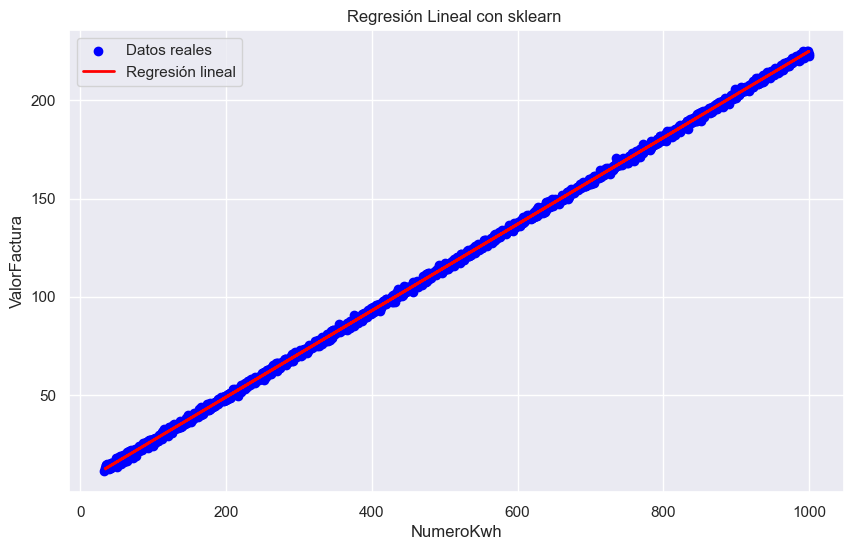

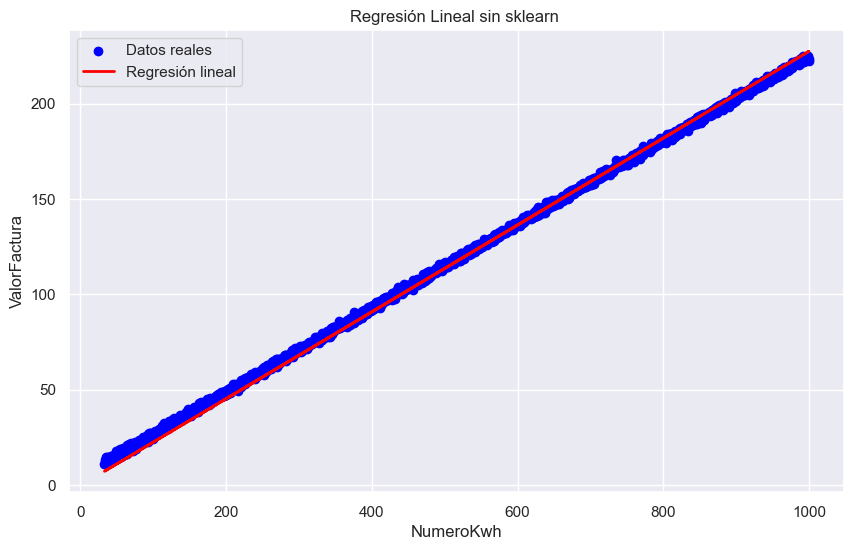

In [19]:
if __name__ == "__main__":
    
    #File = "data/student-mat.csv"
    #Namex = ['age'] # Cambiar a la columna deseada
    #Namey = 'G3'

    File = "data/FacturaXKilovatio.csv"
    Namex = ['NumeroKwh'] # Cambiar a la columna deseada
    Namey = 'ValorFactura'
  
    function = 'Potencia'  # 
    K = 2
    alpha = 0.7
    # Cargar datos
    x_base, y_base = Load_Data_FeatureTarget(Namex, Namey, File, 1)
    # Convertir a numpy arrays
    x_base = np.array(x_base)
    y_base = np.array(y_base)

    x_train, y_train, x_test, y_test = FunctionEntrenar(x_base, y_base, alpha)
    
    repeticiones= 30
    for _ in range(repeticiones):
    # Entrenar el modelo y obtener predicciones
        yhat_test, yhat_train, y_pred_train, y_pred_test= FunctionPredeccir(x_train, x_test, y_train, y_test, alpha, function, K)
        rmse_manual_train_list, r2_manual_train_list, rmse_manual_test_list, r2_manual_test_list, rmse_sklearn_train_list, r2_sklearn_train_list, rmse_sklearn_test_list, r2_sklearn_test_list = RMs(y_train , yhat_train, y_test, yhat_test, y_pred_train, y_pred_test)



    print("\n--- PROMEDIO DE MÉTRICAS EN 30 REPETICIONES ---")
    print(f"Manual - Train: RMSE={np.mean(rmse_manual_train_list):.4f}, R²={np.mean(r2_manual_train_list):.4f}")
    print(f"Manual - Test:  RMSE={np.mean(rmse_manual_test_list):.4f}, R²={np.mean(r2_manual_test_list):.4f}")
    print(f"Sklearn - Train: RMSE={np.mean(rmse_sklearn_train_list):.4f}, R²={np.mean(r2_sklearn_train_list):.4f}")
    print(f"Sklearn - Test:  RMSE={np.mean(rmse_sklearn_test_list):.4f}, R²={np.mean(r2_sklearn_test_list):.4f}")

 
    # Graficar los datos y la línea de regresión
    plt.figure(figsize=(10, 6))
    plt.scatter(x_base[:, 0], y_base, color='blue', label='Datos reales')
    plt.plot(x_train[:, 0], y_pred_train, color='red', linewidth=2, label='Regresión lineal')
    plt.xlabel(Namex[0])
    plt.ylabel(Namey)
    plt.title('Regresión Lineal con sklearn ')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(x_base[:, 0], y_base, color='blue', label='Datos reales')
    plt.plot(x_train[:, 0], yhat_train, color='red', linewidth=2, label='Regresión lineal')
    plt.xlabel(Namex[0])
    plt.ylabel(Namey)
    plt.title('Regresión Lineal sin sklearn ')
    plt.legend()
    plt.grid(True)
    plt.show()

## Analisis de la ejecución con fuente de información bajamente correlacionada
#### Parametros 
File:  Nombre y ruta del archivo a procesas  ejemplo File =  'data/student-mat.csv'

Namex:  Varible que contrendra el Feature.   Ejemplo NameX= 'age'

Namey:  Variable que almacena el target  Ejemplo  Namey= 'G3'
    --- PROMEDIO DE MÉTRICAS EN 30 REPETICIONES ---
Manual - Train: RMSE=4.4353, R²=-0.5198
Manual - Test:  RMSE=4.4154, R²=-0.5253
Sklearn - Train: RMSE=3.5059, R²=0.0255
Sklearn - Test:  RMSE=3.4875, R²=0.0273

El resultado de la ejecución anterior, muestra como el modelo manual vs el de skelearn tiene una leve diferencia en asertividad, mientras el modelo manual llega a un RMSE de 4.43, el de skelearn es de 3.5, Lo anterior permite concluir que ambos modelos no están siendo asertivos para la predicción, pero es importante resaltar que el problema NO SON LOS MODELOS, sino la variable a predeccir, la cual es una variable binaria. 

Ahora, el coeficiente de R al ser negativo ayuda a soportar la conclusión del parrafo anterior, donde se muestra que el modelo no está prediciendo nada. Pero todo se da por la variable target. 

Finalmente, el modelo de sklearn está un poquito mas optimizado, pero la diferencia es muy pequeña. 

## Analisis de la ejecución con fuente de información altamente correlacionada
#### Parametros 
File:  Nombre y ruta del archivo a procesas  ejemplo File =  "data/FacturaXKilovatio.csv"

Namex:  Varible que contrendra el Feature.   Ejemplo NameX= 'NumeroKwh'


Cargando datos de: data/FacturaXKilovatio.csv

--- PROMEDIO DE MÉTRICAS EN 30 REPETICIONES ---

Manual - Train: RMSE=2.6630, R²=0.9981

Manual - Test:  RMSE=2.7898, R²=0.9981

Sklearn - Train: RMSE=0.9853, R²=0.9997

Sklearn - Test:  RMSE=1.0324, R²=0.9997

El resultado de la ejecución anterior, muestra como el modelo manual vs el de skelearn tiene una leve diferencia en asertividad, mientras el modelo manual llega a un RMSE de 2.63, el de skelearn es de 0.9, Lo anterior permite concluir que ambos modelos  están siendo asertivos para la predicción, sin embargo el modelo de sklearn es mucho mas optimo, dado que su RMSE se acerca mas a CERO

Ahora, el coeficiente de R al ser cercano a CERO  ayuda a soportar la conclusión del parrafo anterior, donde se muestra que el modelo SI está prediciendo y que su ajuste es cercano a UNO es decir, estaria cerca al 100%, con un porcentaje de 99.7%
